In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816190644.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816191719.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816184716.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816184836.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816181247.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816190707.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816184311.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816191139.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816190710.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816190058.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816181426.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make tea/IMG20230816183137.jpg
/kaggle/input/taeleaf-dataset/Leaf that uses to make

In [17]:
!pip install torchinfo

# Import Liabraries

In [30]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
import seaborn as sns

# Configuration

In [31]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: No GPU available


# Variables

In [32]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = "/kaggle/input/taeleaf-dataset"
output_dir = "/kaggle/working/processed-dataset"  
checkpoints_path = "/kaggle/working/"
os.makedirs(output_dir, exist_ok=True)

train_batch = 32
test_batch = 16
total_class = 3
learning_rate = 0.0001
decay = 1e-4
epoch = 100
patience = 100

# LOAD DATASET (for datasets without train/valid/test folders)

In [60]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def load_split(split_dir):
    """
    Load image file paths and labels from dataset structured as:
        split_dir/
            ├── Class1/
            ├── Class2/
            └── Class3/
    Returns a DataFrame with [file_path, label]
    """
    file_paths, labels = [], []
    
    for class_name in sorted(os.listdir(split_dir)):
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    file_paths.append(os.path.join(class_dir, image_name))
                    labels.append(class_name)
    
    return pd.DataFrame({"file_path": file_paths, "label": labels})

data_dir = "/kaggle/input/taeleaf-dataset"

data_df = load_split(data_dir)
print("Total images found:", len(data_df))
print("Classes found:", data_df['label'].unique())

train_df, temp_df = train_test_split(data_df, test_size=0.3, stratify=data_df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Valid size: {len(valid_df)}")
print(f"Test size:  {len(test_df)}")

# Optional: preview
train_df.head()


Total images found: 747
Classes found: ['Leaf that not to be used to make tea' 'Leaf that uses to make tea']
Train size: 522
Valid size: 112
Test size:  113


,file_path,label
566,/kaggle/input/taeleaf-dataset/Leaf that uses t...,Leaf that uses to make tea
23,/kaggle/input/taeleaf-dataset/Leaf that not to...,Leaf that not to be used to make tea
59,/kaggle/input/taeleaf-dataset/Leaf that not to...,Leaf that not to be used to make tea
245,/kaggle/input/taeleaf-dataset/Leaf that not to...,Leaf that not to be used to make tea
629,/kaggle/input/taeleaf-dataset/Leaf that uses t...,Leaf that uses to make tea


In [34]:
data_dir = "/kaggle/input/taeleaf-dataset"  

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),         
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder(root=data_dir, transform=transform)
classes = dataset.classes
num_classes = len(classes)
print("Classes found:", classes)
print("Total images:", len(dataset))

Classes found: ['Leaf that not to be used to make tea', 'Leaf that uses to make tea']
Total images: 747


In [36]:
#Split dataset (70% train, 15% valid, 15% test)

train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)} | Valid: {len(valid_dataset)} | Test: {len(test_dataset)}")


Train: 522 | Valid: 112 | Test: 113


# Model setup (offline MobileNetV2)

In [38]:
model = models.mobilenet_v2(weights=None) 
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Offline MobileNetV2 model is ready!")
print(f"Using device: {device}")
print(f"Number of classes: {num_classes}")

Offline MobileNetV2 model is ready!
Using device: cpu
Number of classes: 2


# Training loop

In [41]:
num_epochs = 20
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(valid_loader)
    val_acc = 100. * val_correct / val_total

    # Save history
    train_losses.append(train_loss)
    valid_losses.append(val_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.2f}%")


Epoch [1/20] Train Loss: 0.2094, Train Acc: 92.53% | Valid Loss: 2.4603, Valid Acc: 43.75%
Epoch [2/20] Train Loss: 0.2120, Train Acc: 91.76% | Valid Loss: 2.8314, Valid Acc: 43.75%
Epoch [3/20] Train Loss: 0.1583, Train Acc: 94.64% | Valid Loss: 1.9111, Valid Acc: 43.75%
Epoch [4/20] Train Loss: 0.1817, Train Acc: 94.06% | Valid Loss: 0.2467, Valid Acc: 91.07%
Epoch [5/20] Train Loss: 0.1764, Train Acc: 94.64% | Valid Loss: 0.1856, Valid Acc: 91.96%
Epoch [6/20] Train Loss: 0.1342, Train Acc: 95.79% | Valid Loss: 0.2031, Valid Acc: 96.43%
Epoch [7/20] Train Loss: 0.0700, Train Acc: 97.51% | Valid Loss: 0.2647, Valid Acc: 90.18%
Epoch [8/20] Train Loss: 0.0663, Train Acc: 97.89% | Valid Loss: 0.2920, Valid Acc: 92.86%
Epoch [9/20] Train Loss: 0.0608, Train Acc: 98.28% | Valid Loss: 0.7272, Valid Acc: 82.14%
Epoch [10/20] Train Loss: 0.0864, Train Acc: 96.55% | Valid Loss: 0.7715, Valid Acc: 75.89%
Epoch [11/20] Train Loss: 0.0610, Train Acc: 98.08% | Valid Loss: 0.2905, Valid Acc: 91.0

In [61]:
#Save model

torch.save(model.state_dict(), "/kaggle/working/mobilenetv2_offline.pth")
print("Model saved to /kaggle/working/mobilenetv2_offline.pth")

Model saved to /kaggle/working/mobilenetv2_offline.pth


# PLOT LOSS & ACCURACY CURVES

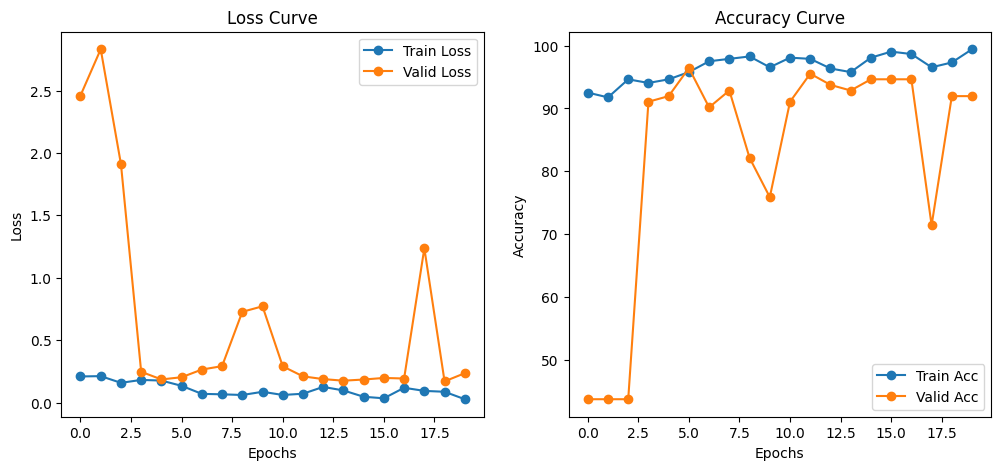

In [43]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(valid_losses, label='Valid Loss', marker='o')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc', marker='o')
plt.plot(valid_accuracies, label='Valid Acc', marker='o')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# TESTING & CONFUSION MATRIX

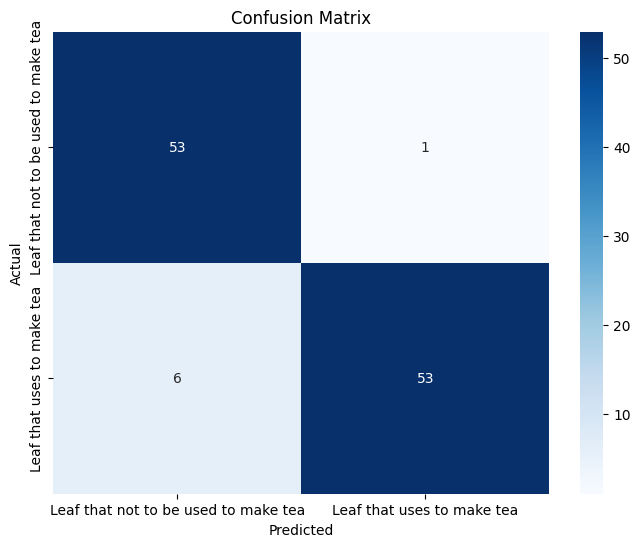

In [45]:
model.eval()
all_preds, all_labels = [], []

# In case class_names isn't defined
if 'class_names' not in locals():
    class_names = dataset.classes

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report

In [62]:

print("\n Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))



 Classification Report:

                                      precision    recall  f1-score   support

Leaf that not to be used to make tea       0.90      0.98      0.94        54
          Leaf that uses to make tea       0.98      0.90      0.94        59

                            accuracy                           0.94       113
                           macro avg       0.94      0.94      0.94       113
                        weighted avg       0.94      0.94      0.94       113



# Evaluate The Model

In [64]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import time
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Collect predictions and true labels
y_true = []
y_pred = []
y_probs = []

start_time = time.time()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

end_time = time.time()
testing_time = end_time - start_time

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# Overall Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Overall Test Accuracy: {acc:.4f}")


Overall Test Accuracy: 0.9381


# ROC Curve & AUC

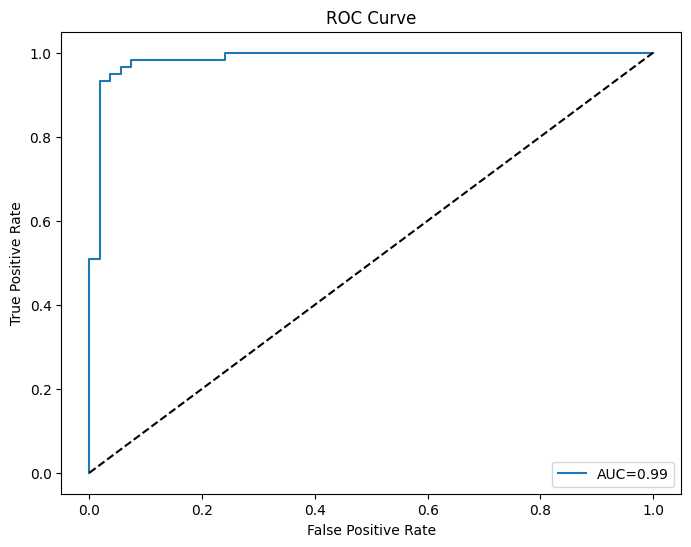

In [66]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

num_classes = len(class_names)

# Binary case
if num_classes == 2:
    # y_probs[:,1] is the probability for positive class
    fpr, tpr, _ = roc_curve(y_true, y_probs[:,1])
    auc_score = roc_auc_score(y_true, y_probs[:,1])
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f"AUC={auc_score:.2f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    # Multi-class case
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        auc_score = roc_auc_score(y_true_bin[:, i], y_probs[:, i])
        plt.plot(fpr, tpr, label=f"{cls} (AUC={auc_score:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


# Traing Time

In [69]:
import time

# Start timer
start_train = time.time()


#Training Loop
num_epochs = 1
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(outputs.argmax(1) == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

# End timer
end_train = time.time()
training_time = end_train - start_train
print(f"Training Time: {training_time:.2f} seconds")


Training Time: 160.35 seconds


# Testing time

In [70]:
start_test = time.time()

# Evaluation on test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

end_test = time.time()
testing_time = end_test - start_test
print(f"Testing Time: {testing_time:.2f} seconds")


Testing Time: 21.27 seconds


# GRAD-CAM VISUALIZATION

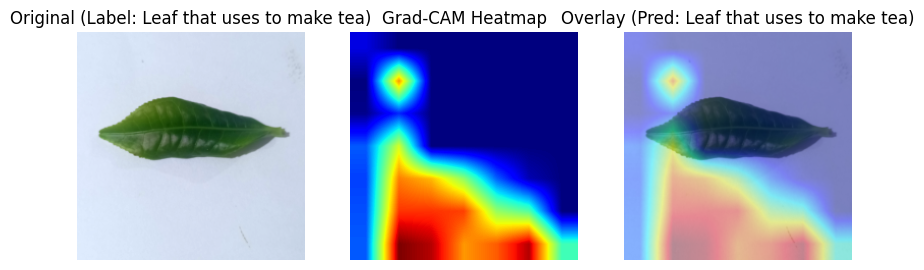

In [59]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

# Pick an image from test set
image_path, _ = test_dataset[0]  # or change index (e.g., test_dataset[10])
# if your dataset returns (image, label)
image, label = test_dataset[0]
input_tensor = image.unsqueeze(0).to(device)

# Get model layer for GradCAM
target_layer = model.features[-1]  # last convolutional layer

# Hook to store gradients
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def forward_hook(module, input, output):
    activations.append(output)

# Register hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Backward pass for predicted class
model.zero_grad()
class_loss = output[0, pred_class]
class_loss.backward()

# Get gradients and activations
grads = gradients[0].cpu().data.numpy()[0]
acts = activations[0].cpu().data.numpy()[0]

# Global average pooling on gradients
weights = np.mean(grads, axis=(1, 2))

# Weighted combination
cam = np.zeros(acts.shape[1:], dtype=np.float32)
for i, w in enumerate(weights[:acts.shape[0]]):  # take min length
    cam += w * acts[i, :, :]


# Normalize CAM
cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam = cam - np.min(cam)
cam = cam / np.max(cam)

# Convert tensor image back to normal RGB
img = image.permute(1, 2, 0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())

# Overlay heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = 0.4 * heatmap / 255 + 0.6 * img
overlay = np.clip(overlay, 0, 1)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title(f"Original (Label: {class_names[label]})")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cam, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title(f"Overlay (Pred: {class_names[pred_class]})")
plt.axis('off')

plt.show()
